# 영화 리뷰 텍스트 감성 분석 프로젝트

### 1. 라이브러리 및 데이터 불러오기

In [1]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2025-08-10 15:36:45--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.1’

ratings_train.txt.1 100%[===================>]  13.95M  28.3MB/s    in 0.5s    

2025-08-10 15:36:46 (28.3 MB/s) - ‘ratings_train.txt.1’ saved [14628807/14628807]

--2025-08-10 15:36:46--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/o

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

In [3]:
!python --version

Python 3.11.13


In [4]:
!pip install gensim==4.3.2

In [5]:
# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.3

In [6]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.2.2
0.6.0
4.3.2


In [7]:
import pandas as pd

# 데이터를 읽어봅시다.
train_data = pd.read_table('/content/ratings_train.txt')
test_data = pd.read_table('/content/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 텍스트 데이터 전처리
- 토크나이저와 불용어를 정의합니다.
- 불용어(stopwords)는 분석에 필요 없는 단어들이므로 해당 단어들은 제거합니다.

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

- 같은 문장이 중복되거나 결측치가 있으면 ```drop_duplicates```와 ```dropna```를 사용해서 제거합니다.
- 학습 데이터는 ```tokenizer.morphs```를 이용하여 문장을 형태소 단위로 분리하고, 불용어 단어도 제거합니다.
- 테스트 데이터도 동일하게 처리합니다.
- 전체 단어 빈도수를 기반으로 상위 num_words - 4개만 추출합니다. (= 가장 많이 나온 상위 9996개의 단어만 사용)

- 단어 사전(vocab)에서 앞의 4칸은 padding, start token, unknown token, unused or custom을 위해 비워둡니다.
- 이후에는 빈도 순으로 단어에 인덱스를 부여합니다.
- 주어진 단어가 사전에 있으면 ```wordlist_to_indexlist```를 통해 해당 인덱스로, 없으면 <UNK> 토큰 인덱스 ``를 사용합니다.
- 학습/테스트 데이터를 인덱스 시퀀스로 변환하고, 전처리가 완료된 학습/테스트 데이터 입력과 정답 라벨, 단어 인덱스 사전을 반환합니다.

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공

#### 데이터셋 내 문장 길이 분포

- 문장 길이 분포를 분석한 그래프입니다.
- 문장의 길이가 5 ~ 20 토큰에 몰려 있고, 8 ~ 10 토큰 근처에서 가장 빈도가 높습니다. (분포 꼬리가 오른쪽으로 긴 편)
- 보통 95 ~ 97 퍼센타일에 해당하는 길이로 ```max_len```을 설정한다고 하여, 밑에서 실습해보도록 하겠습니다.

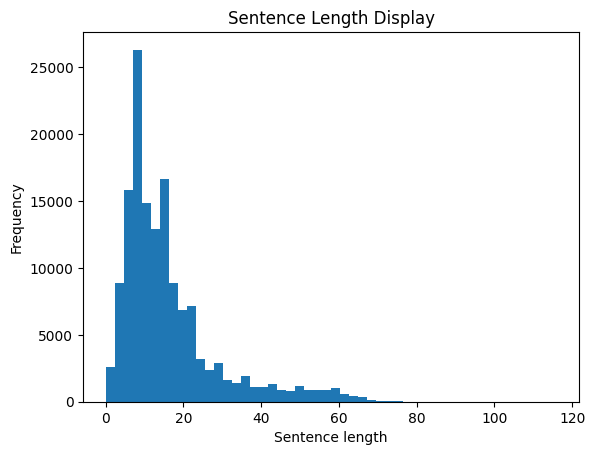

In [11]:
import matplotlib.pyplot as plt

lengths = [len(x) for x in X_train]
plt.hist(lengths, bins=50)
plt.xlabel('Sentence length')
plt.ylabel('Frequency')
plt.title('Sentence Length Display')
plt.show()

#### 적절한 최대 문장 길이 지정

- 문장 길이 분포를 바탕으로 적절한 최대 길이 ```max_len```을 정하고 그 길이에 맞춰 패딩합니다. (```keras.preprocessing.sequence.pad_sequences```을 활용한 패딩 추가)
- ```lengths``` : X_train의 각 문장(토큰 리스트)의 길이를 구해 배열로 만듭니다. (예 : [['나는', '밥을', '먹었다'], ['오늘', '날씨', '좋네']] → [3, 3])
- 퍼센타일(백분위) : 데이터 중 p% 이하에 해당하는 값을 의미하며, 여기서는 출력된 값들을 보고 적절한 ```max_len```을 찾습니다.
- 아래 코드에서는 95 퍼센타일 값인 47을 사용하여, 문장을 최대 47 토큰까지만 쓰기로 합니다.

In [12]:
!pip install keras
!pip install tensorflow

import numpy as np
from keras.preprocessing.sequence import pad_sequences

# 문장 길이 배열
lengths = np.array([len(x) for x in X_train])

# 퍼센타일로 후보 길이 보기
for p in [90, 95, 97, 98, 99]:
    print(p, "percentile:", int(np.percentile(lengths, p)))

# 예시: 95퍼=?? 값을 보고 max_len 결정 (보통 30~40 근처가 나옴)
max_len = int(np.percentile(lengths, 95))  # 예: 35

# 패딩 (pre/post는 일관되게 유지)
X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test,  maxlen=max_len, padding='post', truncating='post')

90 percentile: 33
95 percentile: 47
97 percentile: 54
98 percentile: 57
99 percentile: 61


#### 모델 구성 및 Validation set 구성

- ```build_avg_model``` : 평균 풀링 기반으로 간단한 분류 모델을 정의했습니다.
- ```build_cnn_model``` : CNN 기반 모델로, 지역 패턴(N-gram 특징)에 강하고 학습이 빠릅니다.
- ```build_bilstm_model``` : BiLSTM 기반 모델로, 문맥 파악에 강하고 긴 문장 처리에 유리하다고 합니다.

In [13]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)
vocab_size = len(word_to_index)

In [14]:
from tensorflow.keras import layers, models, optimizers

def build_avg_model(vocab_size, emb_dim=128, max_len= max_len):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inp, out)

model_a = build_avg_model(vocab_size)
model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
def build_cnn_model(vocab_size, emb_dim=128, max_len=max_len):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inp)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inp, out)

model_b = build_cnn_model(vocab_size)
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


- ```mask_zero=True```일 때 임베딩이 생성하는 mask는 LSTM 계열에서는 잘 처리되지만, Conv1D는 마스크 처리를 하지 않아 경고가 떴습니다.
- 빠른 학습이 가능한 환경이 아니어서 시간상 일단 따로 처리하지 않고 진행했습니다. (실험하는 단계에서는 괜찮다고 합니다.)

In [16]:
def build_bilstm_model(vocab_size, emb_dim=128, max_len=max_len):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inp, out)

model_c = build_bilstm_model(vocab_size)
model_c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

- 인덱스 및 타입 이슈가 발생하여, 다시 ```vocab_size```를 계산했습니다.

In [19]:
# 안전하게 vocab_size 계산
vocab_size = max(word_to_index.values()) + 1   # <- 중요!

# 혹시 타입 문제 방지
X_tr = X_tr.astype("int32")
X_val = X_val.astype("int32")
y_tr = y_tr.astype("float32")
y_val = y_val.astype("float32")

# 모델들 다시 build (input_dim=vocab_size 로)
model_a = build_avg_model(vocab_size)
model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_b = build_cnn_model(vocab_size)
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_c = build_bilstm_model(vocab_size)
model_c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#### 모델 훈련 개시

- ```model_a``` : 평균 임베딩 모델(예측 도중 EarlyStopping + 체크포인트 둘 다 적용)
- ```batch_size=512``` : 한 번에 512 샘플 처리
- ```epochs=8``` : 최대 8회 반복(조기 종료가 있을 수 있음)
- ```validation_data``` : 매 epoch마다 검증 데이터로 성능 평가
- ```callbacks``` : 위에서 정의한 es와 ckpt 적용

- ```model_b``` : CNN 모델로, 조기 종료만 적용하고 체크포인트 저장은 하지 않았음

- ```model_c``` : BiLSTM 모델로, 배치 크기를 256으로 줄이고 조기 종료만 적용

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(patience=2, restore_best_weights=True, monitor='val_loss')
ckpt = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history_a = model_a.fit(X_tr, y_tr, epochs=8, batch_size=512,
                        validation_data=(X_val, y_val), callbacks=[es, ckpt])

history_b = model_b.fit(X_tr, y_tr, epochs=8, batch_size=512,
                        validation_data=(X_val, y_val), callbacks=[es])

history_c = model_c.fit(X_tr, y_tr, epochs=8, batch_size=256,
                        validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6642 - loss: nan - val_accuracy: 0.4998 - val_loss: nan
Epoch 2/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5045 - loss: nan - val_accuracy: 0.4998 - val_loss: nan
Epoch 3/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5028 - loss: nan - val_accuracy: 0.4998 - val_loss: nan
Epoch 1/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 48s 205ms/step - accuracy: 0.7551 - loss: 0.4900 - val_accuracy: 0.8566 - val_loss: 0.3316
Epoch 2/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.8900 - loss: 0.2709 - val_accuracy: 0.8678 - val_loss: 0.3146
Epoch 3/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 83s 198ms/step - accuracy: 0.9304 - loss: 0.1912 - val_accuracy: 0.8628 - val_loss: 0.3350
Epoch 4/8
229/229 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.9633 - loss: 0.1150 - val_accuracy: 0.8564 - val_loss: 0.4043
Epoch 1/8
457/457 ━━━━━━━━━━━━━━━━━━━━ 283s 607ms/step - accuracy: 0.7822 - loss: 0.4453 - val_accuracy: 0.8503 -

#### Loss, Accuracy 그래프 시각화

- 평가를 했어야 했는데 오류를 고치느라 깜빡했습니다. (ㅠㅠ)

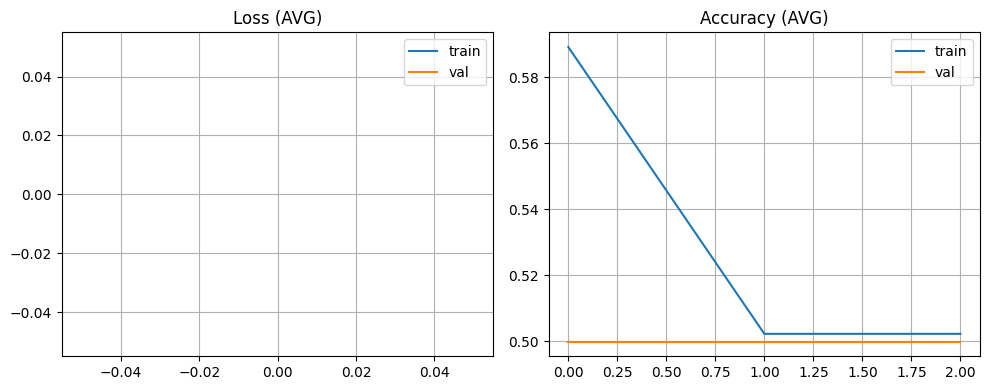

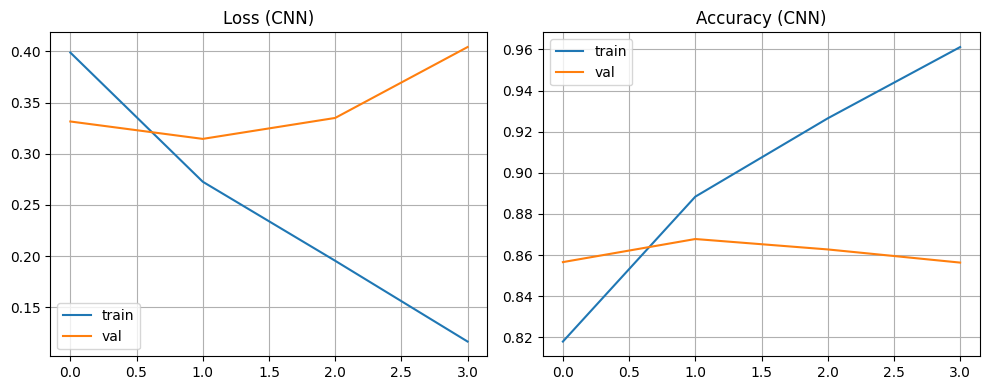

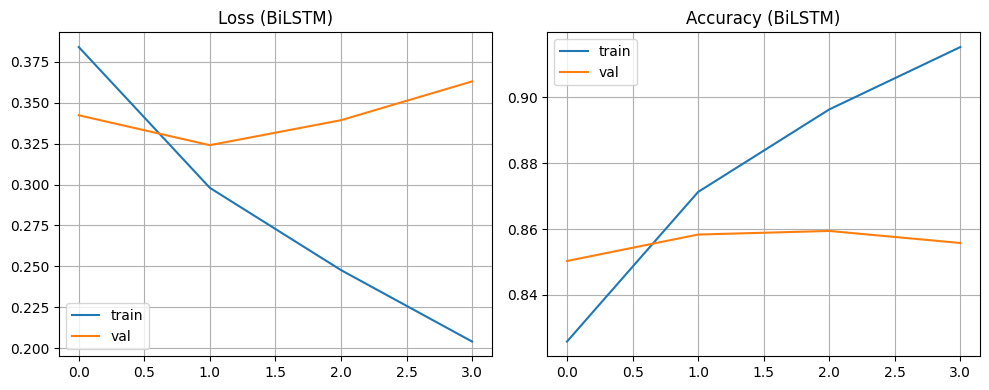

In [21]:
import matplotlib.pyplot as plt

def plot_history(h, title=''):
    plt.figure(figsize=(10,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title(f'Loss {title}'); plt.legend(); plt.grid(True)
    # Acc
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train')
    plt.plot(h.history['val_accuracy'], label='val')
    plt.title(f'Accuracy {title}'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

plot_history(history_a, '(AVG)')
plot_history(history_b, '(CNN)')
plot_history(history_c, '(BiLSTM)')


#### 학습된 Embedding 레이어 분석

- 임베딩 레이어로 학습한 단어 벡터를 이용한 단어 추천기입니다.
- '재밌'과 가장 가까운 단어 10개를 코사인 유사도 순으로 출력합니다.

In [ ]:
import numpy as np

# 임베딩 행렬 추출 (모델 맨 앞 레이어 가정)
emb_matrix = model_c.layers[1].get_weights()[0]  # (vocab_size, emb_dim)

# 단어 → 가장 가까운 단어 k개
def nearest_words(query, k=10):
    if query not in word_to_index:
        return []
    q_idx = word_to_index[query]
    q_vec = emb_matrix[q_idx]
    # 코사인 유사도
    norms = np.linalg.norm(emb_matrix, axis=1, keepdims=True) + 1e-10
    normed = emb_matrix / norms
    sim = normed @ (q_vec / (np.linalg.norm(q_vec)+1e-10))
    # 자기 자신 제외, 상위 k
    top = np.argsort(-sim)[1:k+1]
    return [(index_to_word[i], float(sim[i])) for i in top]

print(nearest_words('재밌', k=10))

[('흥미진진', 0.8826026916503906), ('감탄', 0.8774785995483398), ('앞서간', 0.8748814463615417), ('김동완', 0.8739339709281921), ('여운', 0.8718828558921814), ('흠잡', 0.868485689163208), ('완벽', 0.8674789667129517), ('담백', 0.8668582439422607), ('편한', 0.8668303489685059), ('수작', 0.8659559488296509)]


#### 한국어 Word2Vec 임베딩을 활용하여 성능 개선

- 사전 학습된 Word2Vec 임베딩을 불러와서 BiLSTM 텍스트 분류 모델에 적용합니다.

In [27]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from tensorflow.keras import layers, models

path = '/content/word2vec_ko.model'

# 어떤 형식인지 모르면 try/except로 안전하게 로드
try:
    w2v = Word2Vec.load(path)              # Word2Vec(full)일 때
    def get_vec(tok): return w2v.wv[tok]
    emb_dim = w2v.wv.vectors.shape[1]
    has_word = lambda token: token in w2v.wv.key_to_index  # Gensim 4.x
except Exception:
    w2v = KeyedVectors.load(path)          # KeyedVectors일 때
    def get_vec(tok): return w2v[tok]
    emb_dim = w2v.vectors.shape[1]
    has_word = lambda token: token in w2v.key_to_index     # Gensim 4.x

# vocab_size 안전 계산
vocab_size = max(word_to_index.values()) + 1

# 임베딩 행렬 맞춰 생성
embedding_matrix = np.random.normal(0, 0.01, (vocab_size, emb_dim)).astype('float32')
for w, idx in word_to_index.items():
    if w in ('',):  # 패딩 등은 0 벡터 권장
        embedding_matrix[idx] = np.zeros(emb_dim, dtype='float32')
    else:
        if has_word(w):
            embedding_matrix[idx] = get_vec(w)

# Pretrained 임베딩으로 모델 구성 (고정 or 미세조정)
def build_bilstm_with_w2v(vocab_size, embedding_matrix, max_len=max_len, trainable=False):
    inp = layers.Input(shape=(max_len,))
    emb = layers.Embedding(vocab_size, embedding_matrix.shape[1],
                           weights=[embedding_matrix],
                           trainable=trainable, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(128))(emb)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_w2v = build_bilstm_with_w2v(vocab_size, embedding_matrix, trainable=True)  # 미세조정 권장
hist_w2v = model_w2v.fit(X_tr, y_tr, epochs=8, batch_size=256,
                         validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/8
457/457 ━━━━━━━━━━━━━━━━━━━━ 285s 613ms/step - accuracy: 0.7524 - loss: 0.4930 - val_accuracy: 0.8453 - val_loss: 0.3532
Epoch 2/8
457/457 ━━━━━━━━━━━━━━━━━━━━ 300s 564ms/step - accuracy: 0.8607 - loss: 0.3193 - val_accuracy: 0.8585 - val_loss: 0.3264
Epoch 3/8
457/457 ━━━━━━━━━━━━━━━━━━━━ 283s 610ms/step - accuracy: 0.8912 - loss: 0.2580 - val_accuracy: 0.8627 - val_loss: 0.3231
Epoch 4/8
457/457 ━━━━━━━━━━━━━━━━━━━━ 321s 607ms/step - accuracy: 0.9134 - loss: 0.2132 - val_accuracy: 0.8636 - val_loss: 0.3408
Epoch 5/8
457/457 ━━━━━━━━━━━━━━━━━━━━ 321s 605ms/step - accuracy: 0.9343 - loss: 0.1661 - val_accuracy: 0.8570 - val_loss: 0.3712


- Word2Vec + BiLSTM 모델의 성능을 평가하고 샘플 예측 결과를 출력합니다.

In [ ]:
# 1) 검증 세트 평가
val_loss, val_acc = model_w2v.evaluate(X_val, y_val, verbose=0)
print(f"[Val] Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# 2) 테스트 세트 평가 (있다면)
if 'X_test_pad' in globals() and 'y_test' in globals():
    test_loss, test_acc = model_w2v.evaluate(X_test_pad, y_test, verbose=0)
    print(f"[Test] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# 3) 임의 예측 예시
sample_pred = model_w2v.predict(X_val[:5])
print("예측 확률:", sample_pred.ravel())
print("실제 라벨:", y_val[:5])

[Val] Loss: 0.3231, Accuracy: 0.8627
[Test] Loss: 0.3269, Accuracy: 0.8622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
예측 확률: [0.9849318  0.7780946  0.85211134 0.7825374  0.93462825]
실제 라벨: [1. 1. 1. 1. 1.]


- 2 ~ 3 에포크에서 학습을 멈췄을 때 검증 성능이 가장 좋았어서, 이때 얼리 스탑을 적용했으면 좋을 것 같습니다.
- ```train_loss```는 계속 갑소하는데, ```train_acc```는 계속 증가하고, ```val_loss```는 증가하는데, ```val_acc```는 정체한다는 점에서 과적합 패턴을 보입니다.
- 추후 모델의 복잡도를 축소하고, Drop Out 비율을 증가하거나, 얼리 스탑을 적용하면 개선될 수 있으리라 예상됩니다.

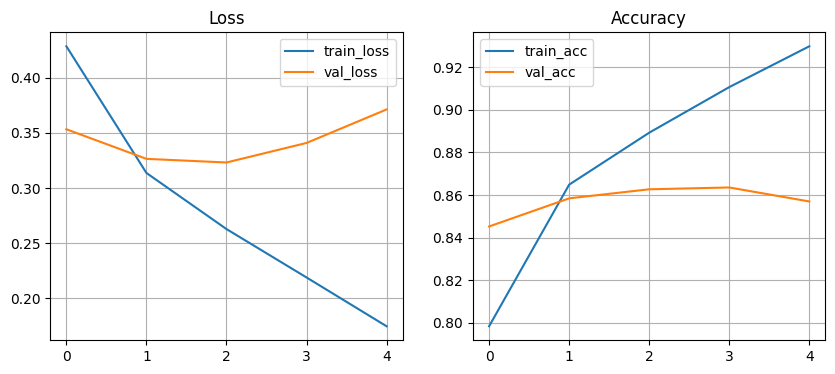

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(hist_w2v)